<a href="https://colab.research.google.com/github/doeungim/ADP_DE/blob/main/ADP_32_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 32회 시험에서는 전처리가 복잡했던 것이 특징, 동형모의고사이며 실제 시험 문제와는 다릅니다.      
    저작권은 datamanim에 있으면 외부유출 및 공개 블로그 깃 등에 업로드를 금지합니다.
- 실제 시험에서는 문제 표기 없습니다.
- 데이터를 코드랑 같은 경로로 위치시켜야 합니다.
- 풀이영상을 보기 전에 4시간 동안 시간을 따로 내어 풀어본 후에 보시길!

In [2]:
from google.colab import files
uploaded = files.upload()

Saving adp32_p1.csv to adp32_p1.csv
Saving adp32_p2.csv to adp32_p2.csv
Saving adp32_p2_sub.csv to adp32_p2_sub.csv
Saving adp32_s1.csv to adp32_s1.csv
Saving adp32_s2.csv to adp32_s2.csv
Saving adp32_s3.csv to adp32_s3.csv


# 32회 ADP 복원

# 기계학습 (60점)

## 데이터 설명
- 데이터 출처 : https://www.kaggle.com/datasets/csafrit2/steel-industry-energy-consumption?resource=download 후처리
- 데이터 링크 : ./data/32/adp32_p1.csv
- 데이터 설명 : 시간대별 발전량에 대한 데이터이다


## 전처리 규칙
- 파생변수 ind11칼럼의 값이 1인 데이터만 훈련에 사용할 것, ind22칼럼의 값이 1인 데이터만 테스트에 사용할 것
- 모든 모델링은 그리드서치를 통해서 최적 파라미터를 산출할 것 (각 모델의 파라미터는 3개 이하로)

In [3]:
import pandas as pd
df = pd.read_csv("adp32_p1.csv")
df.head()

,date,Kwh,LaCR,LeCR,co2,LaF,LeF
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0


## 1-1  date 컬럼을 이용하여 3개의 파생변수를 만들어라
- 1. month : 해당 시각의 월 정보
- 2. day : 해당 시각의 일자 정보, 일요일-0, 월요일-1 ~ 토요일-6
- 3. nsd : 해당 시각의 일자의 자정으로부터 소요된 총 분(minute)

In [4]:
df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y %H:%M')

# 1. Month
df['month'] = df['date'].dt.month

# 2. Day
df['day'] = (df['date'].dt.day_of_week + 1 ) % 7

# nsd
df['nsd'] = df['date'].dt.minute + df['date'].dt.hour * 60
df.head(4)

,date,Kwh,LaCR,LeCR,co2,LaF,LeF,month,day,nsd
0,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,1,1,15
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1,1,30
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,1,1,45
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,1,1,60


## 1-2 아래 기준으로 두개의 파생변수를 추가하라
- 파생변수명(ind11) : month, day, nsd 컬럼의 합이 11의 배수이고 22의 배수가 아니라면 1의 값 그 외는 0의 값
- 파생변수명(ind22) : month, day, nsd 컬럼의 합이 22의 배수라면 1의 값 그 외는 0의 값

In [12]:
df['ind11'] =  (((df['month'] + df['day'] + df['nsd']) % 11 == 0) & ((df['month'] + df['day'] + df['nsd']) % 22 != 0)).astype('int')
df['ind22']  = ((df['month'] + df['day'] + df['nsd']) % 22 == 0).astype('int')


## 1-3 아래 기준으로 한개의 파생변수를 추가하라
- 파생변수명(Kwh8) : Kwh컬럼의 값이 4.1 초과일 경우 1 그 외 0

In [13]:
df['Kwh8'] = df['Kwh'].map(lambda x : 1 if x  >= 4.1 else 0)
df.head(4)

,date,Kwh,LaCR,LeCR,co2,LaF,LeF,month,day,nsd,Kwh8,ind11,ind22
0,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,1,1,15,0,0,0
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1,1,30,0,0,0
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,1,1,45,0,0,0
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,1,1,60,0,0,0


## 1-4 전처리 완료한 데이터를 기준으로 EDA를 실시하라 (시각화 포함)

Index(['Kwh', 'Kwh8', 'LaCR', 'LaF', 'LeCR', 'LeF', 'co2', 'day', 'month',
       'nsd'],
      dtype='object')

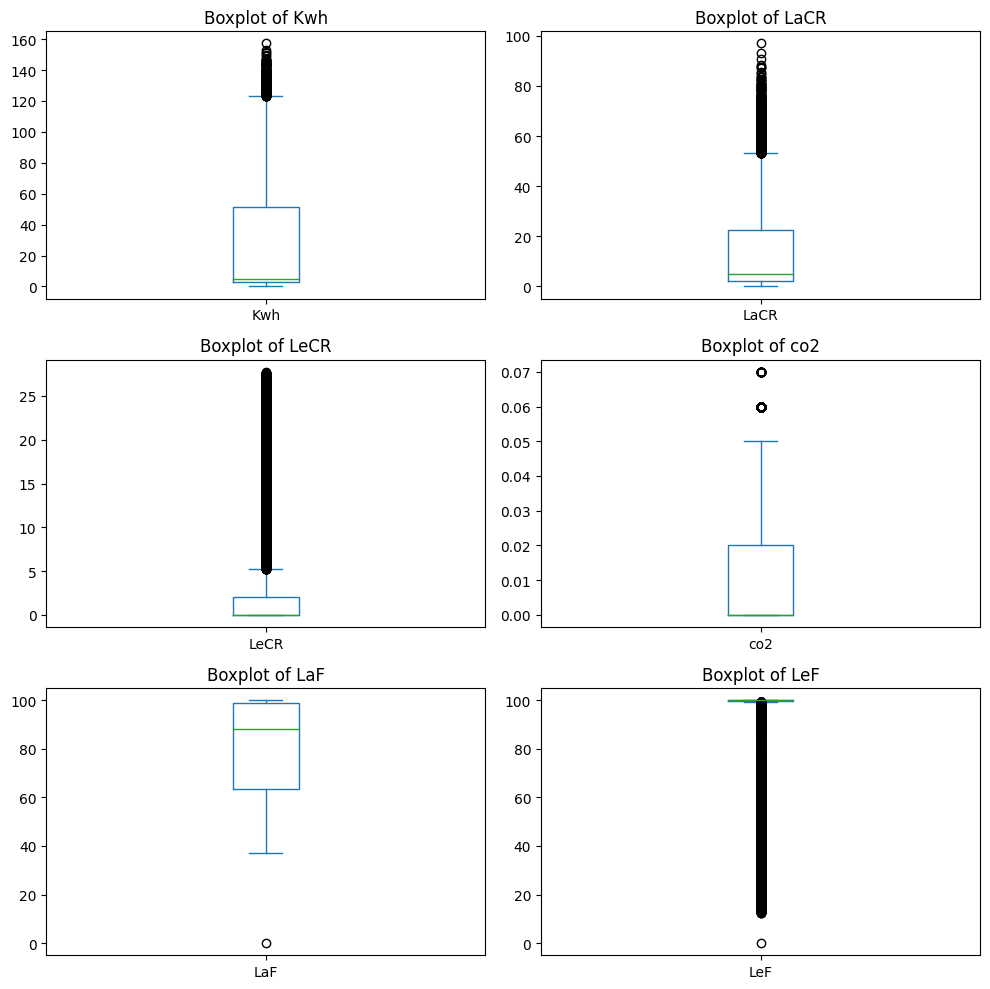

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

remove_col = ['date']
cols = df.columns.difference(remove_col)
display(cols)

plot_df = df.drop(columns = 'date', axis = 1)


fig, axes = plt.subplots(3,2, figsize = (10,10))
axes = axes.flatten()

counter = 0
for col in plot_df.columns:
    # 데이터프레임의 각 열에 대해 박스플롯 생성
    if col in ['Kwh', 'LaCR', 'LaF', 'LeCR', 'LeF', 'co2']:
      plot_df[col].plot(kind='box', ax=axes[counter])
      axes[counter].set_title(f'Boxplot of {col}')
      counter += 1

#    elif col in ['day', 'ind11','ind22','nsd','month'] :
#      sns.countplot(plot_df[col].astype('str'))
 #     plt.title(f'Countplot of {col}')
 #     plt.show()

plt.tight_layout()
plt.show()


## 1-5 Kwh8를 종속 변수로 하여(Kwh제거) 분류 모델을 학습하고 평가하라. 서포트벡터머신과 랜덤포레스트를 사용하라. confusionmatrix를 해석하라

- 파생변수 ind11칼럼의 값이 1인 데이터만 훈련에 사용할 것, ind22칼럼의 값이 1인 데이터만 테스트에 사용할 것
 - 모든 모델링은 그리드서치를 통해서 최적 파라미터를 산출할 것 (각 모델의 파라미터는 3개 이하로)

In [7]:
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


pipe  = Pipeline([('scaler', StandardScaler()), ('svc', SVC)])

In [14]:
df2 = df.drop(columns = ['Kwh','date'], axis = 1)

train = df2.loc[df['ind11'] == 1]
test = df2.loc[df['ind22'] == 1]


train_x = train.drop('Kwh8', axis = 1)
train_y = train['Kwh8']

test_x = test.drop('Kwh8', axis = 1)
test_y = test['Kwh8']


In [15]:
def rf_model(train_x, train_y) :
  ## 모델 생성
  rf = RandomForestClassifier(random_state = 1234)

  # 1) Prarm
  pram_grid = {
      'n_estimators' : [100,10],
      'min_samples_split' : [2,5],
      'min_samples_leaf' : [1,3]

  }
  # 2) GridSerach
  grid_search = GridSearchCV(rf, pram_grid, cv = 3)

  # 3) GridFit
  grid_search.fit(train_x, train_y)
  return grid_search


def svm_model(train_x, train_y) :
  svc = SVC()

  # 1) Param
  param_grid = {
      'svc__C':[1,10],
      'svc__kernel':['linear','rbf'],
      'svc__tol':[0.001,0.01]
  }

  # 2) Pipeline
  pipeline = Pipeline([('scaler' , StandardScaler()), ('svc', SVC())])

  # 3) GridSerearch
  grid_search = GridSearchCV(pipeline, param_grid, refit = True, cv = 3)
  grid_search.fit(train_x, train_y)
  return grid_search


rf = rf_model(train_x, train_y)
svm = svm_model(train_x , train_y)

In [16]:
rf_pred = rf.predict(test_x)
svm_pred = svm.predict(test_x)

## Random Foreset
rf_confusion = pd.DataFrame(confusion_matrix(test_y, rf_pred), columns = ['0_true','1_true'], index  = ['0_guess','1_guess'])
rf_accuracy = accuracy_score(test_y, rf_pred)
rf_f1_score = f1_score(test_y, rf_pred)


## SVM
svm_confusion = pd.DataFrame(confusion_matrix(test_y, svm_pred), columns = ['0_true','1_true'], index  = ['0_guess','1_guess'])
svm_accuracy = accuracy_score(test_y, svm_pred)
svm_f1_score = f1_score(test_y, svm_pred)


pd.DataFrame({'RandomForeset': [rf_accuracy, rf_f1_score],
              'SVM' : [svm_accuracy, svm_f1_score ] } ,
              index = ['Accuracy_Score', 'F1_Score'])

,RandomForeset,SVM
Accuracy_Score,0.948200,0.938724
F1_Score,0.951306,0.942020


## 1-6 Kwh를 종속 변수로 하여(Kwh8 제거) 회귀 모델을 학습하고 평가하라. 서포트벡터머신과 랜덤포레스트를 사용하라

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix , accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [18]:

train = df2.loc[df['ind11'] == 1]
test = df2.loc[df['ind22'] == 1]


train_x = train.drop('Kwh8', axis = 1)
train_y = train['Kwh8']

test_x = test.drop('Kwh8', axis = 1)
test_y = test['Kwh8']

In [19]:
def rf_linear(train_x, train_y) :

  # Model 선언
  rf = RandomForestRegressor()

  # Grid_Search
  parma_grid = {
      'n_estimators' : [100,10],
      'min_samples_split' : [2,5] ,
      'min_samples_leaf' : [1,3]
  }

  # Grid_Search 적용
  grid_ = GridSearchCV(rf, parma_grid, cv = 4)
  grid_search  = grid_.fit(train_x, train_y)
  return grid_search


## ---------------------------------------

def svr_modeling(train_x,train_y):
    svr = SVR()
    param_grid = {
        'svr__C':[1,10],
        'svr__kernel':['linear','rbf'],
        'svr__tol':[0.001,0.01],
    }

    pipeline = Pipeline([('scaler', StandardScaler()), ('svr', SVR())])

    grid_search = GridSearchCV(pipeline,param_grid , refit=True,cv =3)
    grid_search.fit(train_x,train_y)
    return grid_search

rf = rf_linear(train_x, train_y)
svm = svr_modeling(train_x, train_y)


# Predict
rf_pred = rf.predict(test_x)
svm_pred = svm.predict(test_x)


#평가
from sklearn.metrics import mean_squared_error

rf_mse = mean_squared_error(test_y, rf_pred)
svm_mse = mean_squared_error(test_y, svm_pred)



## 1-7 아래 두 조건으로 각각 데이터를 추출하여 회귀 모델링을 하고 1-6과 성능을 비교하라
- Kwh8 값이 1인 데이터만 추출 후 Kwh8 컬럼 제거
- Kwh8 값이 0인 데이터만 추출 후 Kwh8 컬럼 제거

## 데이터 설명
- 데이터 출처 : https://www.data.go.kr/data/15126430/fileData.do 후처리 + 자체제작
- 데이터 링크 :
    - ./data/32/adp32_p2.csv
    - ./data/32/adp32_p2_sub.csv
- 데이터 설명 :
    - 두가지 데이터이다.
    - adp32_p2.csv : J시의 4개의 발전기의 시간당 발전용량에 대한 정보이다.
    - adp32_p2_sub.csv : J시의 시간별 계절성 정보 데이터이다.

In [36]:
p = pd.read_csv('adp32_p2.csv')
weather = pd.read_csv('adp32_p2_sub.csv')
display(p.head())
display(weather.head())

,발전기명,일자,설비용량,0시,1시,2시,3시,4시,5시,6시,...,14시,15시,16시,17시,18시,19시,20시,21시,22시,23시
0,a,2020-01-01,263.225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,93.280,53.840,21.630,5.690,4.610,4.270,1.330,0.530,0.0,0.0
1,b,2020-01-01,245.725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,88.250,51.059,22.283,5.244,4.183,3.848,1.290,0.564,0.0,0.0
2,c,2020-01-01,254.425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,90.641,50.344,22.072,5.652,4.495,4.089,1.240,0.526,0.0,0.0
3,d,2020-01-01,250.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,86.995,51.953,21.831,6.149,4.666,4.141,1.228,0.491,0.0,0.0
4,a,2020-01-02,263.225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.000,25.860,8.310,4.090,0.730,1.070,0.390,0.020,0.0,0.0


,일시,기온,강수량(mm),습도,적설(cm),전운량(10분위),일조(hr),일사량
0,2020-01-01 00:00,2.4,NaN,63.0,0.0,9,0.0,0.0
1,2020-01-01 01:00,2.6,0.0,63.0,0.0,9,0.0,0.0
2,2020-01-01 02:00,2.7,0.0,68.0,0.0,9,0.0,0.0
3,2020-01-01 03:00,3.2,0.0,69.0,0.0,9,0.0,0.0
4,2020-01-01 04:00,3.0,0.0,65.0,0.0,9,NaN,0.0


## 2-1 아래 조건들을 참고하여 전처리를 시행하라
- 계절성 정보 데이터 중 강수량과 일조량의 결측치를 0으로 채워라
- 계절성 정보 데이터 중 기온은 직전시간과 직후시간의 기온의 평균값으로 결측치를 대치하라
- 계절성 정보데이터와 발전용량 데이터를 머지하라.
    - 계절성 정보데이터의 일자,시각을 기준으로 한다.
    - 계절성 정보데이터에 발전기명, 설비용량, 발전량 컬럼을 추가한다.

<img src ='data/32/result.png' width='800' height='200'/>

In [66]:
weather.columns = [col.split('(')[0] for col in weather.columns]

# Fillna
weather[['강수량','일조']] = weather[['강수량','일조']].fillna(0)
weather.head(10)


# 2. 기온은 직전, 직후의 평균
# combine_first 의 함수 : 다른 곳에서 찾아서 대체로 해줌
weather['기온'] = weather['기온'].combine_first((weather['기온'].fillna(method = 'bfill') + weather['기온'].fillna(method = 'ffill')) / 2 )


weather['일시'] = pd.to_datetime(weather['일시'])
weather.head(3)

<ipython-input-66-c1c9462e26d6>:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather['기온'] = weather['기온'].combine_first((weather['기온'].fillna(method = 'bfill') + weather['기온'].fillna(method = 'ffill')) / 2 )


,일시,기온,강수량,습도,적설,전운량,일조,일사량
0,2020-01-01 00:00:00,2.4,0.0,63.0,0.0,9,0.0,0.0
1,2020-01-01 01:00:00,2.6,0.0,63.0,0.0,9,0.0,0.0
2,2020-01-01 02:00:00,2.7,0.0,68.0,0.0,9,0.0,0.0


In [68]:
#p.iloc[:,0:3].melt()
p_melt = p.melt(p.iloc[:,0:3]).rename(columns = {'variable':'시각', 'value': '발전량'})

# zfill 함수 : 5일 때 str(number).zfill(2) = 05로 만들어줌
p_melt['일시'] = pd.to_datetime(p_melt['일자']+'  ' + p_melt['시각'].str.replace('시','').str.zfill(2))
p_melt = p_melt.drop(columns  = ['일자','시각'], axis = 1)
p_melt.head(3)

,발전기명,설비용량,발전량,일시
0,a,263.225,0.0,2020-01-01
1,b,245.725,0.0,2020-01-01
2,c,254.425,0.0,2020-01-01


In [72]:
# Merge
df = pd.merge(p_melt, weather, on = '일시')


## 2-2 전처리 데이터를 기준으로 아래 조건으로 train,test 데이터를 나눈다. 데이터 분리 후 train 데이터의 기초 통계량을 확인하라
- a발전기의 12시~18시의 데이터만 모델링에 사용한다.
- 2020년도, 2021년도는 train, 2022년도는 test 데이터로 사용한다

In [115]:
import warnings
import matplotlib.pyplot as plt

# 특정 경고 무시
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")



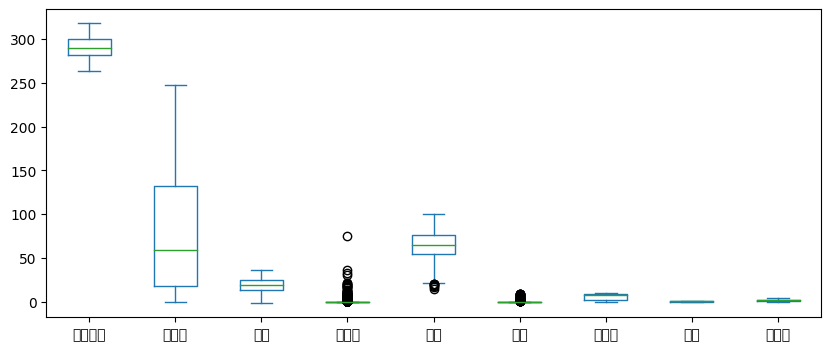

In [116]:
model_df= df.loc[(df.iloc[:,0] == 'a') & (df.일시.dt.hour.between(12,18))]

train = model_df[model_df['일시'].dt.year.isin([2020,2021])].reset_index(drop =True)
train['일시'].dt.year.value_counts()

test = model_df[model_df['일시'].dt.year == 2022].reset_index(drop = True)
# test['일시'].dt.year.value_counts()

fig , ax = plt.subplots(figsize = (10,4))
train.loc[:, ~train.columns.isin(['발전기명', '일시'])].plot(kind = 'box' , ax= ax)

plt.show()

## 2-3 train 데이터 세트의 발전량과 나머지 변수간의 상관관계를 확인하라


In [193]:
train.loc[:, ~ train.columns.isin(['발전기명','일시'])].corr()[['발전량']].sort_values(by = '발전량')[:-1]


,설비용량,발전량,기온,강수량,습도,적설,전운량,일조,일사량
0,263.225,146.45,5.1,0.0,59.0,0.0,9,0.0,0.65
1,263.225,33.12,8.9,0.0,66.0,0.0,10,0.0,0.31
2,263.225,86.10,11.1,0.0,63.0,0.0,8,0.3,1.08
3,263.225,175.35,10.2,0.0,60.0,0.0,4,0.6,1.44
4,263.225,162.51,10.3,0.0,50.0,0.0,4,1.0,1.81
...,...,...,...,...,...,...,...,...,...
5105,318.119,3.17,5.5,0.0,66.0,0.0,9,0.0,0.00
5106,318.119,2.00,7.8,0.0,65.0,0.0,7,0.0,0.00
5107,318.119,3.42,10.0,0.0,57.0,0.0,9,0.0,0.00
5108,318.119,3.53,7.5,0.0,52.0,0.0,9,0.0,0.00


## 2-4 발전량을 종속변수로 하여 2개의 회귀모델링을 진행하고 모델을 평가하라

In [127]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train/ Test
x_train = train.drop(['발전기명','발전량','일시'], axis = 1)
y_train = train.발전량


x_test = test.drop(['발전기명','발전량','일시'], axis = 1)
y_test = test.발전량


# Model
rf = RandomForestRegressor()
lr = LinearRegression()

def modelling(model, name) :
  model.fit(x_train, y_train)
  pred = model.predict(x_test)
  acc = mean_squared_error(pred, y_test)

  return {name:acc}, model

lst = {}
model_lst = []

for models in ([rf, 'RandomForeset'], [lr, 'Linear']) :
  model = models[0]
  name = models[1]
  acc, model = modelling(model, name)
  lst.update(acc)
  model_lst.append(model)

pd.DataFrame(lst.items(), columns = ['Model', 'Score'])



,Model,Score
0,RandomForeset,1263.081116
1,Linear,1349.727525


# 통계 (40점)

## 데이터 설명
- 데이터 출처 : https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset 후처리
- 데이터 링크 : ./data/32/adp32_s1.csv
- 데이터 설명 : 보스턴 집값 관련 데이터
    - MEDV (집값): 종속변수

In [130]:
df = pd.read_csv('adp32_s1.csv')
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT1,LSTAT2,MEDV
0,0.00632,18.0,2.31,0.0,0.538,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,5.0520,24.0
1,0.02731,0.0,7.07,0.0,0.469,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,9.4440,21.6
2,0.02729,0.0,7.07,0.0,0.469,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,3.8970,34.7
3,0.03237,0.0,2.18,0.0,0.458,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,2.9410,33.4
4,0.06905,0.0,2.18,0.0,0.458,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,5.4075,36.2


## 3-1 기본 회귀가정을 검토하라

1. 선형성
 - 독립 변수와 종속 변수와의 관계는 선형적이여야 한다.
 - 잔차(residual)과 예측값 사이의 산점도를 그린다.
2. 독립성
 - 오차항은 서로 독립적이여야한다.
 - 검토를 위해 Durbin-Watson 으로 자기 상관을 확인한다.
3. 등분산성
 - 오차항의 분산은 모든 독립 변수 값에서 일정해야한다.
4. 정규성
 - 오차항은 정규분포를 따라야한다.
5. 다중 공선성
 - 독립 변수간들의 강한 상관관계가 없어야 한다. (VIF)

In [141]:
import statsmodels.api as sm

X = df.drop(columns = 'MEDV', axis= 1)
y = df['MEDV']

# Linear Model

x = sm.add_constant(X)

lr_model = sm.OLS(y,x).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     87.03
Date:                Mon, 19 Aug 2024   Prob (F-statistic):          2.09e-118
Time:                        06:56:23   Log-Likelihood:                -1538.2
No. Observations:                 506   AIC:                             3104.
Df Residuals:                     492   BIC:                             3164.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.4437      3.888     17.860      0.000      61.804      77.083
CRIM          -0.1181      0.036     -3.288      0.001      -0.189      -0.048
ZN             0.0657      0.015      4.483      0.000       0.037       0.095
INDUS         -0.0313      0.066     -0.472      0.637      -0.161       0.099
CHAS           2.9475      0.932      3.164      0.002       1.117       4.778
NOX          -20.9226      4.118     -5.081      0.000     -29.014     -12.832
AGE            0.0257      0.014      1.836      0.067      -0.002       0.053
DIS           -1.7140      0.214     -8.011      0.000      -2.134      -1.294
RAD            0.4019      0.071      5.675      0.000       0.263       0.541
TAX           -0.0148      0.004     -3.660      0.000      -0.023      -0.007
PTRATIO       -1.1462      0.140     -8.197      0.000      -1.421      -0.871
B              0.0068      0.003      2.340      0.020       0.001       0.012
LSTAT1        -0.5449      0.557     -0.978      0.329      -1.640       0.550
LSTAT2        -0.2274      0.556     -0.409      0.683      -1.319       0.865
==============================================================================
Omnibus:                      126.656   Durbin-Watson:                   1.246
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              298.364
Skew:                           1.281   Prob(JB):                     1.63e-65
Kurtosis:                       5.754   Cond. No.                     1.28e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [158]:

# 필요 라이브러리 불러오기
import matplotlib.font_manager as fm
import os
import matplotlib.pyplot as plt

# apt-get : 패키지 설치 명령어
# -qq : 에러외의 메세지 숨기는 옵션키
!apt-get -qq install fonts-nanum


fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정



Text(0, 0.5, 'Residuals')

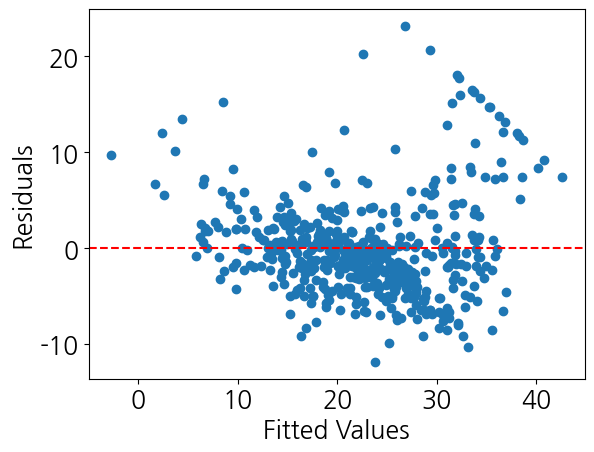

In [164]:
## 1. 선형성 - Model

plt.scatter(lr_model.fittedvalues, lr_model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

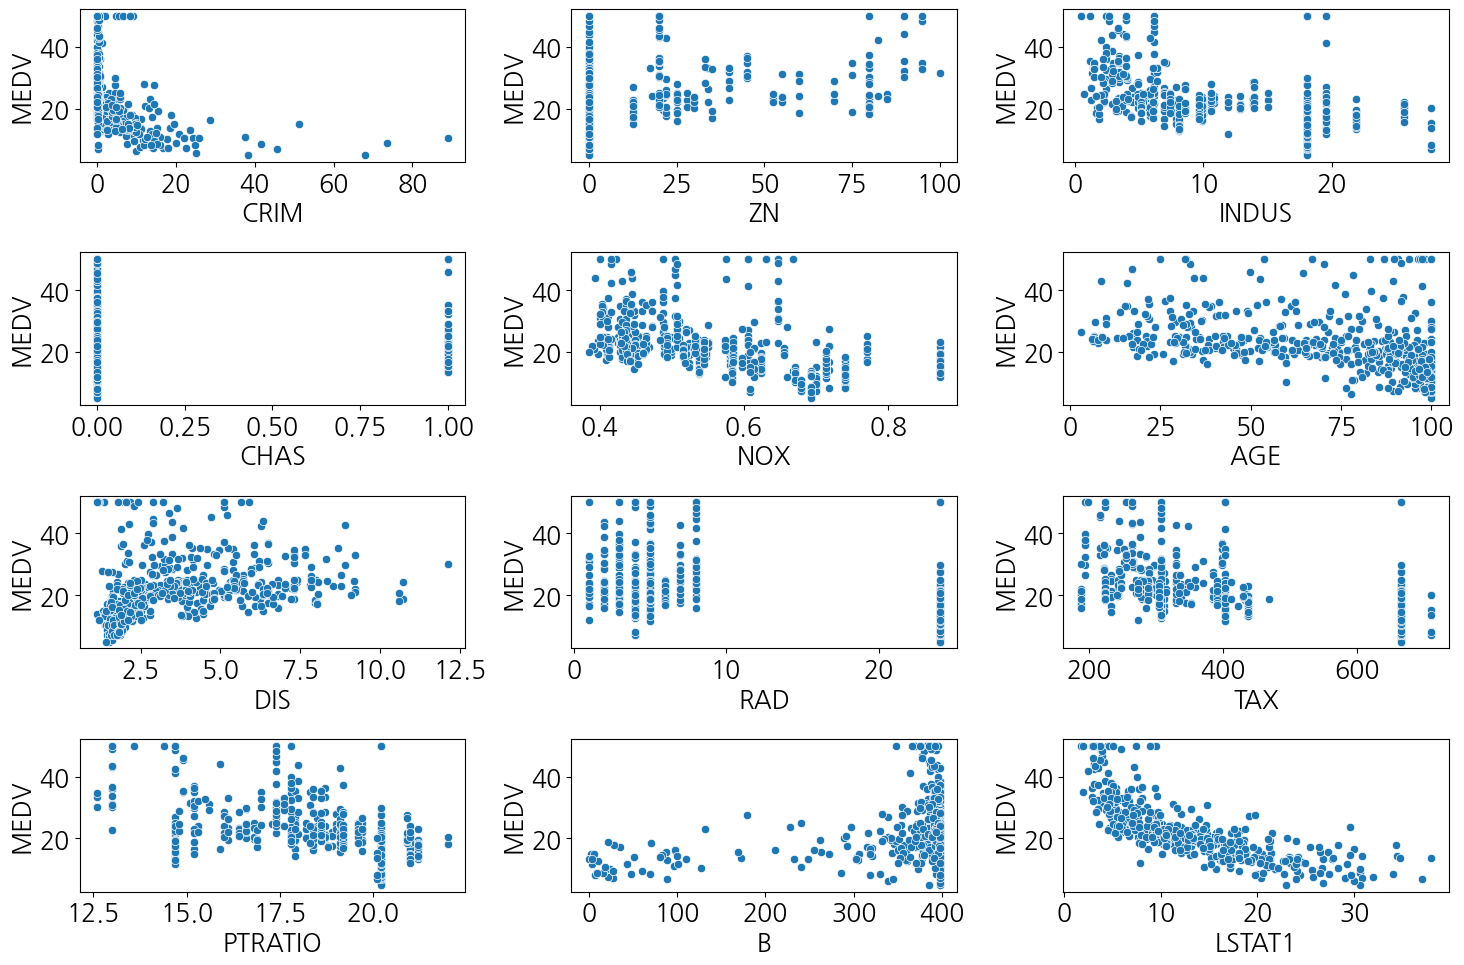

In [183]:
# 선형성 2

fig, axes = plt.subplots(4, 3, figsize = (15,10))

for i , ax in enumerate(axes.flat[:]):
  col_i = df.columns[i]
  sns.scatterplot(x = df[col_i], y = df['MEDV'] , ax = ax)
  ax.set_xlabel(col_i)


plt.tight_layout()
plt.show()


In [184]:
# 독립성 - 오차항의 독립성
from statsmodels.stats.stattools import durbin_watson
## 0~4 의 값을 가지며, 2에 가까울 수록 자기 상관이 높은것
## 2와의 비교: 출력된 값이 2에 가까울수록 잔차가 독립적이라고 판단
durbin_watson(lr_model.resid)

1.245613025169305

In [187]:
## 등분산성
# HO : 잔차의 분산이 일정하다 (등분산이다)

import statsmodels.stats.api as sms
static, p_val, f_stats, f_pv = sms.het_breuschpagan(lr_model.resid , lr_model.model.exog)
print(p_val)

1.6419500179628714e-06


In [189]:
from scipy.stats import shapiro
stats, pv = shapiro(lr_model.resid)
pv

5.437687047001666e-16

## 3-2 변수간 관계 검토하고 문제점 해결방안 2가지를 제시하라

In [202]:
cor_table = df.loc[:, ~ df.columns.isin(['MEDV'])].corr().unstack().reset_index()
cor_table.columns = ['Cor1', 'Cor2', 'Corr']

## 중복 내용은 삭제
cor_table[cor_table['Cor1'] != cor_table['Cor2']].sort_values(by = 'Corr').reset_index(drop = True)

print('''
  강한 양/음의 상관관계를 가지는 컬럼들이 존재하여, 다중 공선성이 발생 할 수 있기 때문에 ,
  1. VIF 값을 기준으로 변수를 제거
  2. PCA 를 이용한 차원을 축소하여 진행
''')

,Cor1,Cor2,Corr
0,DIS,NOX,-0.769230
1,NOX,DIS,-0.769230
2,DIS,AGE,-0.747881
3,AGE,DIS,-0.747881
4,DIS,INDUS,-0.708027
...,...,...,...
151,NOX,INDUS,0.763651
152,TAX,RAD,0.910228
153,RAD,TAX,0.910228
154,LSTAT1,LSTAT2,0.998273


In [218]:
## 1. 다중공선성 : 10 이상의 변수를 제거하여 해결하는 것이 일반적임
from statsmodels.stats.outliers_influence import variance_inflation_factor

## MEDV 제거
vif_df = df.drop('MEDV', axis = 1)

## vif 넣는 데이터 프레임 생성
vif = pd.DataFrame()

vif['factors']= [variance_inflation_factor(vif_df.values, i) for i in range(vif_df.shape[1])]
vif['features'] = vif_df.columns
display(vif)

vif_remove_columns = list(vif.loc[vif.factors >= 50].features)
print(vif_remove_columns)

,factors,features
0,2.145961,CRIM
1,2.676664,ZN
2,13.979173,INDUS
3,1.148943,CHAS
4,55.834349,NOX
5,20.452306,AGE
6,14.254318,DIS
7,15.105923,RAD
8,61.259393,TAX
9,66.683432,PTRATIO


['NOX', 'TAX', 'PTRATIO', 'LSTAT1', 'LSTAT2']


In [234]:
df2 = df[df.columns.difference(vif_remove_columns)]
df2

X = df.drop('MEDV', axis = 1)
y = df['MEDV']

X_ = sm.add_constant(X)

model = sm.OLS(y, X_).fit()
model.summary()


## 1. 독립성
print(durbin_watson(model.resid))

## 2. 등분산성 p < a 기각
# 귀무 : 등분산이다.
print(sms.het_breuschpagan(model.resid , model.model.exog)[1])

## 3. 정규성
print(shapiro(model.resid)[1])

1.245613025169305
1.6419500179628714e-06
5.437687047001666e-16


## 3-3 3-2에서 제안한 것을 반영하여 문제를 해결하고 적용 결과를 제시하라

In [245]:
## 방법 2) PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## 정규화
sc = StandardScaler()
scaled_df = pd.DataFrame(sc.fit_transform(df.drop('MEDV', axis = 1)), columns = df.drop('MEDV', axis = 1).columns)

## PCA 적용
pca = PCA(n_components = 7)
pca_df = pca.fit_transform(scaled_df)

X = pca_df
y = df['MEDV']

X_ = sm.add_constant(X)

model = sm.OLS(y, X_).fit()
model.summary()


## 1. 독립성
print(durbin_watson(model.resid))

## 2. 등분산성 p < a 기각
# 귀무 : 등분산이다.
print(sms.het_breuschpagan(model.resid , model.model.exog)[1])

## 3. 정규성
print(shapiro(model.resid)[1])

1.1109963398346778
8.523994222466545e-10
6.982058146539838e-17


## 데이터 설명
- 데이터 출처 : https://www.rdocumentation.org/packages/datasets/versions/3.6.2/topics/mtcars 후처리
- 데이터 링크 : ./data/32/adp32_s2.csv
- 데이터 설명 : 차량정보데이터

## 4-1 cyl랑 gear 컬럼으로 교차테이블을 만들어라

In [249]:
df = pd.read_csv('adp32_s2.csv')
cross = pd.crosstab(df['cyl'], df['gear'])

## 4-2 두 범주형 변수간 차이가 존재하는지 확인하려한다. 귀무가설과 대립가설을 작성하라

범주형 변수간의 차이를 확인하는 것이므로 카이제곱 독립성 검정을 시행한다.     
귀무가설은 두 범주형 변수는 독립이다.    
대립가설은 두 범주형 변수는 독립이 아니다.

In [251]:
from scipy.stats import chi2_contingency

chi2, p, dof , expected = chi2_contingency(cross)
print(p)

0.0012140660337851554


## 4-3 통계검정을 실시하고 해석하라

## 5-1 각 성별의 급여 데이터가 정규성을 만족하는지 확인하라.

In [288]:
import pandas as pd
df = pd.read_csv('adp32_s3.csv')

# Ho : 정규성을 만족한다.
# H1 : 정규성을 만족하지 않는다.
m = df.loc[df.iloc[:,0] == '남']['급여']
print(shapiro(m)[1])

f = df.loc[df.iloc[:,0] == '여']['급여']
print(shapiro(f)[1])

print(shapiro(m)[1] , '귀무가설 기각 ' if shapiro(m)[1] < 0.05 else  '귀무가설 채택' )
print(shapiro(f)[1] , '귀무가설 기각' if shapiro(f)[1] < 0.05 else  '귀무가설 채택' )

0.4064899452692996
5.044551735541618e-06
0.4064899452692996 귀무가설 채택
5.044551735541618e-06 귀무가설 기각 


## 5-2 위 결과에 맞는 남녀 월급 차이가 있는지 확인 하기 위한 검정 전략을 설명하라

In [292]:
## 정규성 검정 결과 - 정규성을 만족하지 않는다.

# 만 휘트니 검정 - 두 집단의 차이를 비교할 때
# 예) 두 그룹의 학생 시험 성적이 정규분포를 따르고 있지 않는 경우,
#      특정 치료를 받은 환자와 그렇지 않은 경우의 만족도 점수가 "순위형" 일떄

# 1. 정규분포가 아닌 경우
# 2. 표본의 크기가 작은 경우
# 3. 순위, 서열 데이터인 경우
# 4. 두 집단의 분포의 차이를 비교할때
# p_value < 0.05 (귀무: 두 집단이 분포가 동일하다)를 기각 할 수 있다.


print('''
  H0 (귀무가설) : 남녀의 월급차는 동일하다.
  H1 (대립가설) : 남녀의 월급차가 존재한다.

  여성의 경우, 정규분포를 따르지 않기 때문에 만 휘트니 검정을 수행한다.
''')


  H0 (귀무가설) : 남녀의 월급차는 동일하다. 
  H1 (대립가설) : 남녀의 월급차가 존재한다.

  여성의 경우, 정규분포를 따르지 않기 때문에 만 휘트니 검정을 수행한다.



## 5-3 가설에 따른 검정을 수행하고, 검정통계량과 p-value를 설명하라

In [295]:
from scipy.stats import mannwhitneyu

print(mannwhitneyu(m,f)[1] , '귀무가설 기각 ' if mannwhitneyu(m,f)[1] < 0.05 else  '귀무가설 채택' )

1.1773484087410562e-07 귀무가설 기각 
